In [1]:
import msgpack
import open3d as o3d
# import trimesh
from IPython.display import display, Math
import numpy as np
import matplotlib.pyplot as plt
import time
import threading
import copy

import ipywidgets.widgets as widgets
import ipywidgets
from IPython.display import display

plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'

# %autoawait off

import socket
# import asyncio
# # # !pip install nest-asyncio
# import nest_asyncio
# # nest_asyncio.apply() 

###########################################

PI = np.pi
TWO_PI = 2*np.pi

# UDP header constant
UDP_RESET=15
UDP_ROBOT_STATE_REPORT=14
UDP_MOTOR_SPEED_COMMEND=13
UDP_MOTOR_POS_COMMEND=12


ip_local = "127.0.0.1"
port_local = 32000

ip_remote = "127.0.0.1"
port_remote = 32001

BUFFER_LEN = 512 #in bytes

local_address = (ip_local,port_local)
remote_address = (ip_remote,port_remote)

packer = msgpack.Packer(use_single_float=True,use_bin_type =True)

### Create a UDP socket

In [2]:
# https://adaickalavan.github.io/programming/udp-socket-programming-in-cpp-and-python/
# Python UDP Receiver
#Create a datagram socket
sock = socket.socket(socket.AF_INET, # Internet
                     socket.SOCK_DGRAM) # UDP
#Enable/disable immediate reuse of IP address
sock.setsockopt(socket.SOL_SOCKET,socket.SO_REUSEADDR,0)
#Set a timeout so the socket does not block indefinitely when trying to receive data
sock.settimeout(1)
#Bind the socket to the port
sock.bind(local_address)
# sock.connect(remote_address)

# for closing connection:
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

### test receiving udp packet

In [3]:
s = time.perf_counter()
try:
    data = sock.recv(BUFFER_LEN)
    data_unpacked = msgpack.unpackb(data)
    print(data_unpacked)
except Exception as e:
    print(e)
    pass
# sock.shutdown(socket.SHUT_RDWR) # shutdown the connection
# sock.close()# close the connection

elapsed = time.perf_counter() - s

print(f"#--- executed in {elapsed*1000:0.2f} ms ---#")


[14, 15.954000000001997, [0.0026297283301664103, 0.0026865773921040496, -0.002578282385410798, -0.0026372955683199545], [-0.0012393751155446303, -0.001406738773056422, 0.0011985840484773306, 0.0012393403340071711], [-0.0013942521658354512, -0.0011448713401557723, 0.012719580457732249], [0.0007691214578073202, 0.9999988694364143, -0.001292121540793656, 0.00368226559713986, 0.0012892810549850187, 0.9999923893082554], [1.931499948581627e-05, -3.7273154878028236e-05, 0.03309054474898494]]
#--- executed in 0.43 ms ---#


### test sending udp packet

In [5]:
# sen_sock = initUDP(ip_remote, port_local) # socket that send udp packet

# data_send = [UDP_RESET,time.time(),[0,0,0,0]]
data_send = [UDP_MOTOR_SPEED_COMMEND,time.time(),[2,2,-2,-2]]

# data_send = [0.5,0.0,1.0,2.0]
# data_send = [1,2,3,4]

# data_send = 20

data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# data_send_packed = msgpack.packb(data_send)

num_bytes_send = sock.sendto(data_send_packed,remote_address)

print(data_send)
print(data_send_packed)

[13, 1600973693.2841005, [2, 2, -2, -2]]
b'\x93\r\xcaN\xbe\xd9\xd7\x94\x02\x02\xfe\xfe'


In [4]:
w_max = round(650.0/60.0*np.pi*2)

pos_max = np.pi

# flag_start = True
# flag_should_send = False
# flag_reset = False

# stop button
button_stop = widgets.Button(
    description='stop',
    icon='stop',
    button_style='warning')

def OnClickButtonStop(b):
    global flag_start
    flag_start=False
button_stop.on_click(OnClickButtonStop)  

# reset button
button_reset = widgets.Button(
    description='reset',
    icon='refresh',
    button_style='info')
def OnClickButtonReset(b):
    global flag_reset
    flag_reset = True
button_reset.on_click(OnClickButtonReset) 


# restart button
button_restart = widgets.Button(
    description='restart',
    icon='refresh',
    button_style='warning')

def OnClickButtonRestart(b):
    OnClickButtonReset(b)
    flag_start=True
    data_send = (UDP_RESET,time.time(),(0, 0, 0, 0))
    data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
    sock.sendto(data_send_packed,remote_address)
#     print("restarted")
button_restart.on_click(OnClickButtonRestart) 

slider_layout=ipywidgets.Layout(width='250px')

joint_vel_widgets = [
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout),#front left 
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout),#back left  
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout),#front right
    widgets.FloatSlider(min=-w_max, max=w_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout)#back right 
]

joint_pos_widgets = [
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout),#front left 
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout),#back left  
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout),#front right
    widgets.FloatSlider(min=-pos_max, max=pos_max, step=.01, value=0,
                                   continuous_update=False, description="",disabled=True,layout=slider_layout)#back right 
]

speed_widget = widgets.FloatSlider(min=-int(w_max/2.5), max=int(w_max/2.5), step=1, value=0.0,
                                   continuous_update=False, description="Speed")

s_base_widget = widgets.FloatSlider(min=0.1, max=0.9, step=.02, value=0.6,
                                   continuous_update=False, description="s base")

s_offset_widget = widgets.FloatSlider(min=-0.16, max=0.16, step=.02, value=0.0,
                                   continuous_update=False, description="s offset")


joint_labels = [
    widgets.Label(value='front left'),
    widgets.Label(value='back left'),
    widgets.Label(value='front right'),
    widgets.Label(value='back right'),
]



caption_list = [
    widgets.Label(value='[Joint Angle]'),
    widgets.Label(value='[Joint speed]'),
    widgets.Label(value='[Accelerration]'),
    widgets.Label(value='[Orientation]'),
    widgets.Label(value='[Position]'),
    widgets.Label(value='[velocity]'),
]

caption_title = [
    widgets.Label(value='[Joint Angle]'),
    widgets.Label(value='[Joint speed]'),
    widgets.Label(value='[Accelerration]'),
    widgets.Label(value='[Orientation]'),
    widgets.Label(value='[Position]'),
    widgets.Label(value='[velocity]'),
]

caption_widget = widgets.HBox([widgets.VBox(caption_title),widgets.VBox(caption_list)])

ui_vel_pos_widget = widgets.HBox([
    widgets.VBox([widgets.Label("")]+joint_labels),
    widgets.VBox([widgets.Label(" joint vel [rad/s]")]+joint_vel_widgets),
    widgets.VBox([widgets.Label("joint pos [rad]")]+joint_pos_widgets)])

ui = widgets.VBox([ui_vel_pos_widget]+[speed_widget,s_base_widget,s_offset_widget,caption_widget])

# def f(w0, w1, w2, w3):
#     global flag_should_send
#     flag_should_send = True
# #     time_now = time.time()
# #     data_send = (UDP_MOTOR_SPEED_COMMEND,time_now,(w0, w1, w2, w3))
# # #     display(data_send)
# # #     data_send_packed = msgpack.packb(data_send)
# #     data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
# # #     display(data_send_packed)
# #     sock.sendto(data_send_packed,remote_address)
# # #     display((f"{time.time():3.3f}", (w0, w1, w2, w3)))
    
# out = widgets.interactive_output(f, {
#     'w0': joint_vel_widgets[0],
#     'w1': joint_vel_widgets[1],
#     'w2': joint_vel_widgets[2],
#     'w3': joint_vel_widgets[3]
# })
# out.layout.height = '350px'
# out.layout.width = '350px'


buttons_ui = widgets.HBox((button_stop,button_reset,button_restart))

# app = widgets.VBox(
#     children = (ui, out,buttons_ui))
app = widgets.VBox(
    children = (ui,buttons_ui))
# display(app)

17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003
17.499999999999993 90.0 162.50000000000003


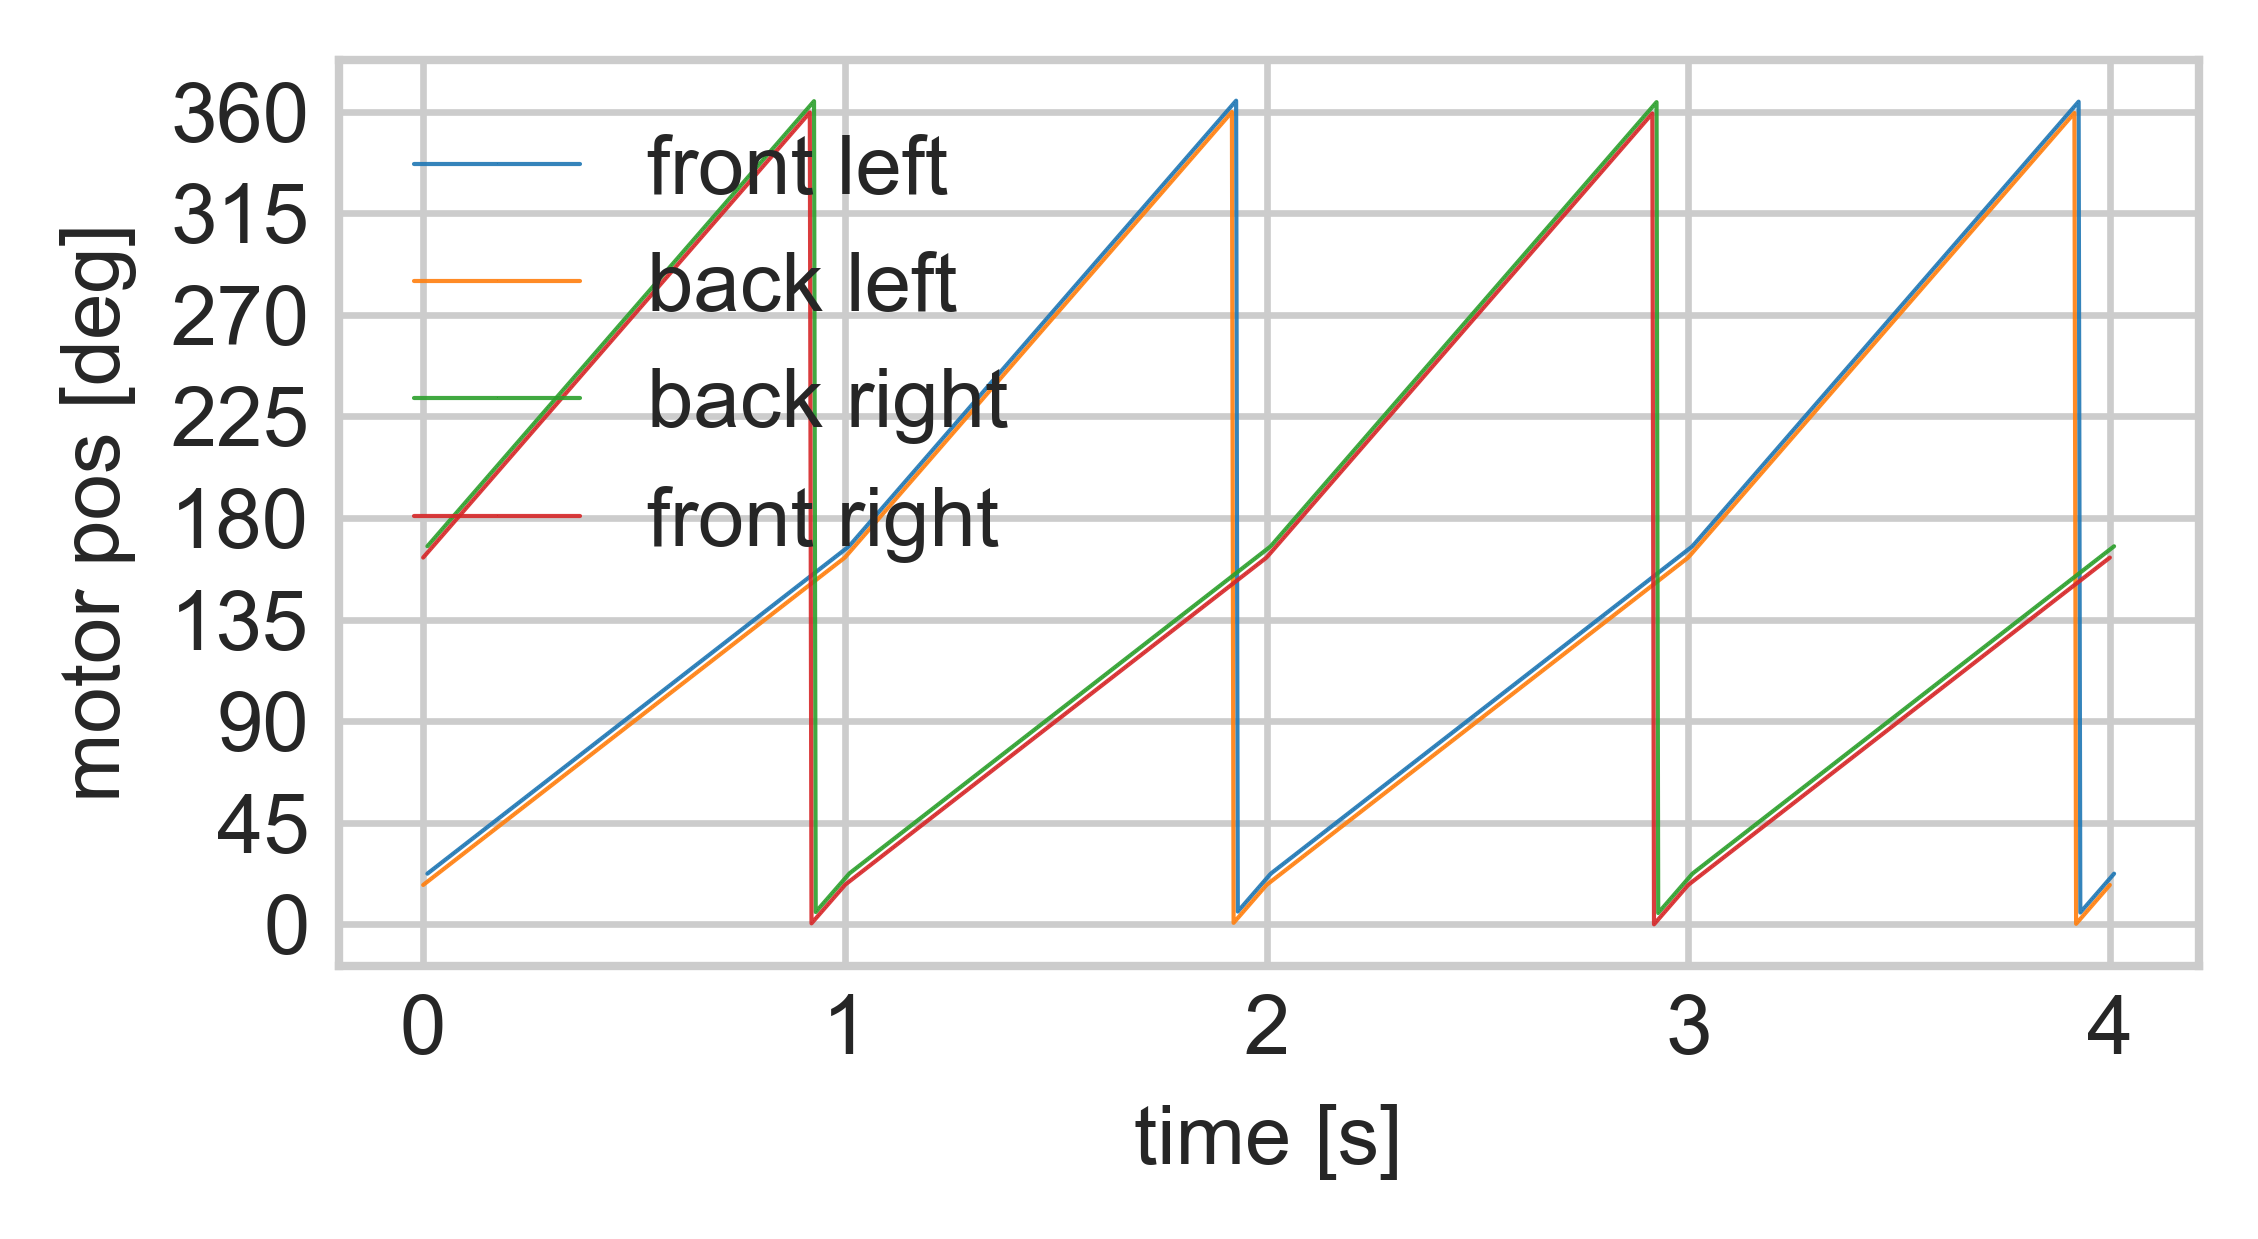

In [5]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-whitegrid')
%config InlineBackend.figure_format = 'retina'


PI = np.pi
TWO_PI = 2*np.pi

class WalkingTrot():
    """
  trotting gait
  @author: HonboZhu, BoxiXia
  """
    def __init__(this,
                 ot = 0, # normalized time offset [0-1], [unitless]
                 w = 0.1*np.pi, # average angular velocity [rad/s]
                 s = 0.5, # stance ratio = stance_time/cycle_time [unitless]
                 contact_angle = 120/180*PI, # contact_angle [rad]
                 p_stance_mid = 1.*np.pi,# angle at the middle of the stance phase [rad]
                 t =0, # time at current step
                ):
        this.ot = ot # normalized time offset [0-1], [unitless]
        assert(0<=this.ot<=1)
        this.w = w # average angular velocity [rad/s]
        this.c = contact_angle # contact_angle [rad]
#         this.contact_angle
        this.p_stance_mid = p_stance_mid       
        this.p_stance_low = p_stance_mid - this.c/2.0
        
        this.t = t # time at current step
        this.tc = this.ot # converted time [0-1,unitless]
        
        this.T = 2*np.pi/this.w # cycle time
        
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = this.c/(this.s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        this.wa = (TWO_PI-this.c)/(1-this.s) # w_air, (time normalized) average angular velocity of air phase [rad]
        
        this.p_stance_high = p_stance_mid + this.c/2.0
        print(np.rad2deg(this.p_stance_low),np.rad2deg(p_stance_mid),np.rad2deg(this.p_stance_high))
        
        # get the initial position
        if this.ot<this.s: # if normalized time offset < stance ratio
            this.pos = this.p_stance_low + this.c/this.s*this.ot
        else:
            this.pos = this.p_stance_low + this.c + (TWO_PI-this.c)/(1-this.s)*(this.ot-this.s)
        
#     @njit
#     def UpdateStanceRatio(this,s):
#         """
#         update the stance ratio s (=: stance_time/cycle_time [unitless])
#         """
#         ws = this.c/(s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
#         wa = (TWO_PI-this.c)/(1-s) # w_air, (time normalized) average angular velocity of air phase [rad]
#         # update the converted (normalized) time this.tc
        
#         pos_raw = (this.pos -this.p_stance_low)%TWO_PI
#         if pos_raw<0:
#             pos_raw+=TWO_PI # convert to 0-2PI
#         if pos_raw<this.c:
#             this.tc = pos_raw/ws
#         else:
#             this.tc = (pos_raw-this.c)/wa+s
            
#         this.s = s # stance ratio = stance_time/cycle_time [unitless]
#         this.ws = ws
#         this.wa = wa

    def UpdateStanceRatio(this,s):
        """
        update the stance ratio s (=: stance_time/cycle_time [unitless])
        """
        ws = this.c/(s) # w_stance, (time normalized) average angular velocity of stance phase [rad]
        wa = (TWO_PI-this.c)/(1-s) # w_air, (time normalized) average angular velocity of air phase [rad]
        # update the converted (normalized) time this.tc
        
        this.s = s # stance ratio = stance_time/cycle_time [unitless]
        this.ws = ws
        this.wa = wa
        
        if this.tc<this.s: # 0-s
            this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
        else: # s-1
            this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
            


    def GetPos(this, t,w=None,s=None):
        """
        return the position [0,2pi] [rad] given the current time [s]
        """
        if w is not None:
            this.w = w
        if (s is not None) and s!=this.s:
            this.UpdateStanceRatio(s)
        dt = t - this.t # differenct in raw time
        this.t = t
        dnt = this.w*dt/TWO_PI # normalized phase difference [0-1][unitless]
        this.tc = (this.tc + dnt)%1.0 # # current converted time [0-1,unitless]
        
        # todo sign
        if this.tc<this.s: # 0-s
            this.pos = (this.p_stance_low + this.ws*this.tc)%TWO_PI
        else: # s-1
            this.pos = (this.p_stance_low + this.c+this.wa*(this.tc-this.s))%TWO_PI
        return this.pos

    def _UpdateAngularVelocity(this,t,w):        
        this.w = w # TODO direction
    


gaits = [ # trotting gait #2 alternate gait
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
    WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back right
    WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI)] # front right


# gaits = [ # trotting gait #2 alternate gait
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI),# front left
#     WalkingTrot(0.7,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI), # back right
#     WalkingTrot(0.7,p_stance_mid = 1./2.*np.pi,contact_angle = 145/180*PI)] # front right

# gaits = [ # bounding gait
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI),# front left
#     WalkingTrot(0.4,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI), # back left
#     WalkingTrot(0.4,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 160/180*PI) # front right
# ]

# gaits = [ # bounding gait same phase
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI),# front left
#     WalkingTrot(0.20,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back left
#     WalkingTrot(0.20,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI) # front right
# ]

# gaits = [ # bounding gait same phase
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI),# front left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back left
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI), # back right
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 180/180*PI) # front right
# ]


# gaits = [ # crawl gait #2
#     WalkingTrot(0,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI),# front left
#     WalkingTrot(0.75,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI), # back left
#     WalkingTrot(0.25,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI), # back right
#     WalkingTrot(0.5,p_stance_mid = 1./2.*np.pi,contact_angle = 120/180*PI) # front right
# ]



t_arr = np.linspace(0,4,1000)
w_arr = PI*np.ones_like(t_arr)
s_arr = np.linspace(0.5,0.5,1000)
# w_arr[300:] = -2*PI

# w_arr = np.linspace(0,2*TWO_PI,1000)


angle1 = np.array([gaits[0].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
angle2 = np.array([gaits[1].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
angle3 = np.array([gaits[2].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])
angle4 = np.array([gaits[3].GetPos(t,w,s) for t,w,s in zip(t_arr,w_arr,s_arr)])

# angle3 = 2*np.pi-angle1
# angle4 = 2*np.pi-angle2
# motor_pos = np.stack((angle1,angle2,angle3,angle4),axis=1)

# vel1 = np.array([trot.GetVel(phase) for phase in t_arr])
# vel2 = np.array([trot.GetVel(phase+0.5) for phase in t_arr])
# vel3= -vel1
# vel4= -vel2
# motor_vel = np.stack((vel1,vel2,vel3,vel4),axis=1)

plt.figure(figsize=(4,2),dpi=300)
plt.plot(t_arr+0.01,np.rad2deg(angle1)+5,',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='front left')
plt.plot(t_arr,np.rad2deg(angle2),',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='back left')
plt.plot(t_arr+0.01,np.rad2deg(angle3)+5,',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='back right')
plt.plot(t_arr,np.rad2deg(angle4),',-',markersize=0.5,linewidth=0.5,alpha=0.9,label='front right')

plt.yticks(np.arange(0, 360+45, 45))

plt.ylabel("motor pos [deg]")
plt.xlabel("time [s]")
plt.legend()
plt.show()

In [6]:
update_interval = 1/400 - 1e-5

display_update_interval = 1/10

speed_update_interval = 2.0

def AppControl():
    time_previous = 0
    display_timer = 0
    speed_timer = 0
    speed = 0.0 # speed of the robot
    previous_pos = np.array((0.,0.,0.))
    
    global joint_vel_widgets
    global flag_start
    global flag_reset
    flag_reset = False
    flag_start=True
    new_receive = False
    
    s_offset = 0.5
    s_base = 0.5
    
    pos_cmd  = np.zeros(4,dtype=np.float64) # joint positions command 
    vel_cmd  = np.zeros(4,dtype=np.float64) # joint velocities command

    # previously commanded joint velocity
    joint_vel_prev = np.asarray((w.value for w in joint_vel_widgets))
    
    desired_speed = speed_widget.value = 0
    
    while flag_start:
        try:
            data_receive= sock.recv(BUFFER_LEN)
            data_receive_unpacked = msgpack.unpackb(data_receive)
            new_receive = True
            time_now = data_receive_unpacked[1]
        except socket.timeout:
#             print("rec_socket timed out!\r",end='')
            pass

        time_now = time.time()
#         display(time_now)
        motor_pos_meas = np.asarray(data_receive_unpacked[2])
        # assumming motor_pos_meas is in [-pi,pi]

        for k in range(4):
#                 joint_vel_widgets[k].value = 10.0*motor_vel_cmd[k]
            pos = gaits[k].GetPos(time_now)
            if k>=2:
                pos = TWO_PI- pos 
            if pos>PI:
                pos=pos-TWO_PI      
            pos_cmd[k] = pos

            pos_error = pos - motor_pos_meas[k]

            if pos_error>PI:
                pos_error =-TWO_PI+pos_error
            elif pos_error<-PI:
                pos_error = TWO_PI+pos_error

            if abs(desired_speed)<10:
                 vel_cmd[k] = (1+abs(desired_speed))*pos_error
            else:
                vel_cmd[k] = 20*pos_error
                
        if time_now - display_timer>display_update_interval:
            display_timer = time_now
            if flag_reset:
                flag_reset = False
                speed_widget.value = 0
                
            # update speed
            if time_now - speed_timer> speed_update_interval:
                speed_timer = time_now
                pos = np.asarray(data_receive_unpacked[6])
                speed = np.linalg.norm((pos- previous_pos)[:2])/speed_update_interval
                previous_pos = pos
                caption_list[-1].value = f"{speed:<10.3f}"

                
            desired_speed = speed_widget.value
            for k in range(4):
                joint_pos_widgets[k].value = pos_cmd[k]
                joint_vel_widgets[k].value = vel_cmd[k]
#                 if k==0 or k==3:
                gaits[k]._UpdateAngularVelocity(time_now,desired_speed)
#                 else:
#                     gaits[k]._UpdateAngularVelocity(time_now,0.5*desired_speed)
                
            if (s_offset!=s_offset_widget.value) or (s_base!=s_base_widget.value):
                s_offset = s_offset_widget.value
                s_base = s_base_widget.value
                for k in range(4):
                    if k<=2:
                        gaits[k].UpdateStanceRatio(s_base-s_offset)
                    else:
                        gaits[k].UpdateStanceRatio(s_base+s_offset)

            # data checking the header should be a certain number(TODO)
            if new_receive:
#                 and data_receive_unpacked[0]:
                new_receive = False
#                     caption_list.value=f"{data_receive_unpacked}"

                for k,caption in enumerate(caption_list[:-1]):
                    caption.value = " ".join(f"{x:<+10.3f}" for x in data_receive_unpacked[2+k])            
        # send data
        data_send = (UDP_MOTOR_SPEED_COMMEND,time_now,vel_cmd.tolist())
#             display(data_send)
        data_send_packed = packer.pack(data_send) # https://msgpack-python.readthedocs.io/en/latest/api.html#msgpack.Packer
        sock.sendto(data_send_packed,remote_address)
#             print(f"{np.fmod(time_now,1.0)*100}\r",end='')
            
    print("exit")
    
control_thread = threading.Thread(target=AppControl)
display(app)
control_thread.start()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## rotation

In [111]:
from scipy.spatial.transform import Rotation as R
def RotateFromVec(vec, angle):
    vec = np.asarray(vec, dtype=np.float64)
    vec_norm = np.linalg.norm(vec)
    if vec_norm != 1:
        vec = vec/vec_norm
    vec *= angle
    h = np.eye(4)
    h[:3, :3] = R.from_rotvec(vec).as_dcm()
    return h       

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/matrixToQuaternion/
def RotMatrixToQuarternion(m):
    """
    m is a 3x3 rotation matrix or 4x4 homogenious transformation matrix
    """
    w = np.sqrt(1+m[0,0]+m[1,1]+m[2,2])/2.0
    w4 = 4*w
    x = (m[2,1]-m[1,2])/w4
    y = (m[0,2]-m[2,0])/w4
    z = (m[1,0]-m[0,1])/w4
    return np.array([w,x,y,z])

# https://www.euclideanspace.com/maths/geometry/rotations/conversions/quaternionToAngle/index.htm
def QuarternionToAxisAngle(q):
    if(q[0]>1):
        q = q/np.linalg.norm(q)
    angle = 2.0 * np.arccos(q[0])
    s = np.sqrt(1-q[0]**2)
    if(s<1e-8):
        return q[1:],angle
    else:
        return q[1:]/s,angle

In [5]:
m = RotateFromVec([0,1,1],np.pi/2.)
q = RotMatrixToQuarternion(m)
QuarternionToAxisAngle(q)

C:\Users\boxi\.conda\envs\conda_env\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `as_dcm` is deprecated!
as_dcm is renamed to as_matrix in scipy 1.4.0 and will be removed in scipy 1.6.0
  if __name__ == '__main__':


(array([0.        , 0.70710678, 0.70710678]), 1.5707963267948966)